# Baby step jump into quantum computing with Qiskit
---
created by M. Y. Hanna [muha207(at)brin.go.id]()

## 0. Before we start

In [1]:
import qiskit
version = qiskit.__version__
print("The version of Qiskit is", version)

The version of Qiskit is 1.0.2


## 1. Construct a quantum circuit

### 1.1 Build circuit

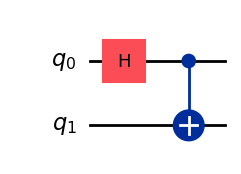

In [2]:
from qiskit import QuantumCircuit

# Create a Quantum Circuit acting on the q register
circ = QuantumCircuit(2)
# Apply H-gate to the first
circ.h(0)
# Apply a CNOT-gate with control qubit 0 and target qubit 1
circ.cx(0, 1)

# Draw the circuit
circ.draw('mpl')

### 1.2 Time-evolution circuits 

These circuits simulate a quantum state evolving in time. Use time-evolution circuits to investigate physical effects such as heat transfer or phase transitions in a system. Time-evolution circuits are also a fundamental building block of chemistry wave functions (such as unitary coupled-cluster trial states) and of the QAOA algorithm we use for optimization problems.

See the [Circuit Library API documentation](https://docs.quantum.ibm.com/api/qiskit/circuit_library) for a list of supported instructions.

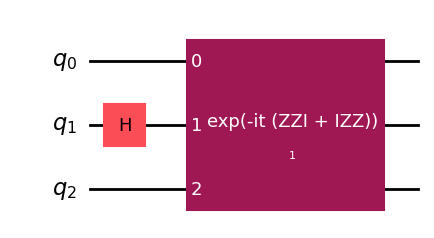

In [3]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# Prepare an initial state with a Hamadard on the middle qubit
circ_2 = QuantumCircuit(3)
circ_2.h(1)

hamiltonian = SparsePauliOp(["ZZI", "IZZ"])
evolution = PauliEvolutionGate(hamiltonian, time=1)

# Evolve state by appending the evolution gate
circ_2.compose(evolution, inplace=True)

# Draw the circuit
circ_2.draw('mpl')

### 1.3 Combine two different circuit

To combine two circuits, use the [`compose`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#compose) method. This accepts another [`QuantumCircuit`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit) and an optional list of qubit mappings.

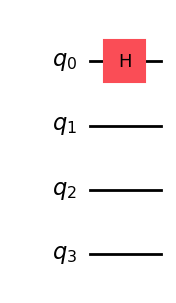

In [4]:
circ_a = QuantumCircuit(4)
circ_a.h(0)
circ_a.draw('mpl')

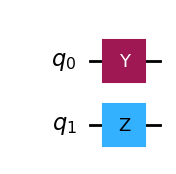

In [5]:
circ_b = QuantumCircuit(2, name="circ_b")
circ_b.y(0)
circ_b.z(1)

circ_b.draw('mpl')

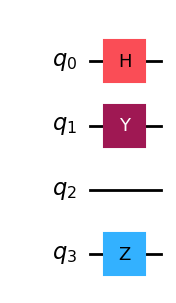

In [6]:
# compose qubits (0, 1) of circ_a to qubits (1, 3) of circ_b respectively
combined = circ_a.compose(circ_b, qubits=[1, 3])
combined.draw('mpl')

You might also want to compile circuits into instructions to keep your circuits organized. You can convert a circuit to an instruction by using the [`to_instruction`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#to_instruction) method, then append this to another circuit as you would any other instruction. The circuit drawn in the following cell is functionally equivalent to the circuit drawn in the previous cell.


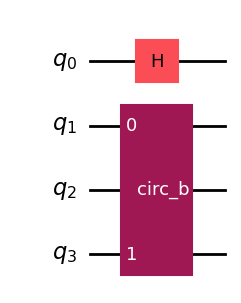

In [7]:
# append circ_b to qubits (1, 3) of circ_a respectively
inst = circ_b.to_instruction()
circ_a.append(inst, [1, 3])
circ_a.draw('mpl')

If your circuit is unitary, you can convert it to a [`Gate`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.Gate) by using the [`to_gate`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#to_gate) method. `Gate` objects are specific types of instructions that have some extra features, such as the control method, which adds a quantum control.

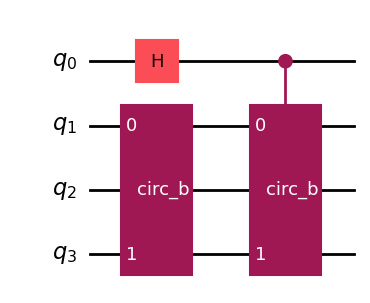

In [8]:
gate = circ_b.to_gate().control()
circ_a.append(gate, [0, 1, 3])
circ_a.draw("mpl")

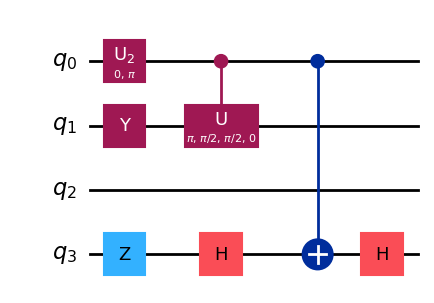

In [9]:
circ_a.decompose().draw("mpl")

### 1.4 Parameterized circuits

Many near-term quantum algorithms involve executing many variations of a quantum circuit. Since constructing and optimizing large circuits can be computationally expensive, Qiskit supports **parameterized** circuits. These circuits have undefined parameters, and their values do not need to be defined until just before executing the circuit. This lets you move circuit construction and optimization out of the main program loop.  The following cell creates and displays a parameterized circuit.

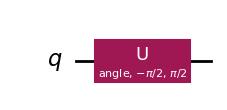

In [10]:
from qiskit.circuit import Parameter
angle = Parameter("angle")  # undefined number

# Create and optimize circuit once
qc = QuantumCircuit(1)
qc.rx(angle, 0)

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
qc = generate_preset_pass_manager(optimization_level=3, basis_gates=['u', 'cx']).run(qc)

qc.draw("mpl")

The following cell creates many variations of this circuit and displays one of the variations.

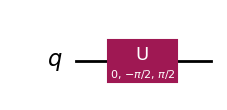

In [11]:
circuits = []
for value in range(50):
    circuits.append(
        qc.assign_parameters({ angle: value })
    )

circuits[0].draw("mpl")

## 2. Analyze a quantum circuit 

### 2.1 Compute the statevector 

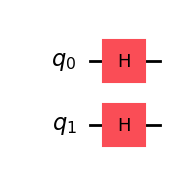

In [12]:
import qiskit.quantum_info as qi

circ_3 = QuantumCircuit(2)
circ_3.h([0,1])
circ_3.draw('mpl')

$|\psi_{f}\rangle = \hat{H}|\psi_{i}\rangle$. it should be noted that $\psi_{i}\rangle$ is the initial state of the system is $|0\rangle$ or spin up. If you want to change become spin down, you can use the `X` gate.

In [13]:
# Create a statevector from the circuit
psi_circ_3 = qi.Statevector(circ_3)
# Print the statevector
# psi_circ_3.data 
psi_circ_3.draw('latex')

<IPython.core.display.Latex object>

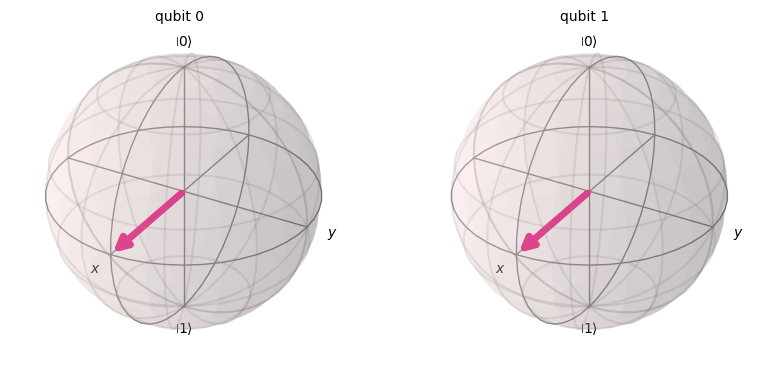

In [14]:
psi_circ_3.draw('bloch')

### 2.2 Compute the unitary matrix

In [15]:
# Compute unitary matrix from the circuit 
unitary_circ_3 = qi.Operator(circ_3)
# Print the unitary matrix
unitary_circ_3.data

array([[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j],
       [ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j],
       [ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
       [ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j]])

### 2.3 Compute the probability of measuring a state

In [16]:
probs_circ_3 = psi_circ_3.probabilities()
probs_circ_3

array([0.25, 0.25, 0.25, 0.25])

### 2.4 Compute the density matrix 

$\rho = |\psi\rangle\langle\psi|$

In [17]:
rho_circ_3 = qi.DensityMatrix(circ_3)
rho_circ_3.data

array([[0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j],
       [0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j],
       [0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j],
       [0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j]])

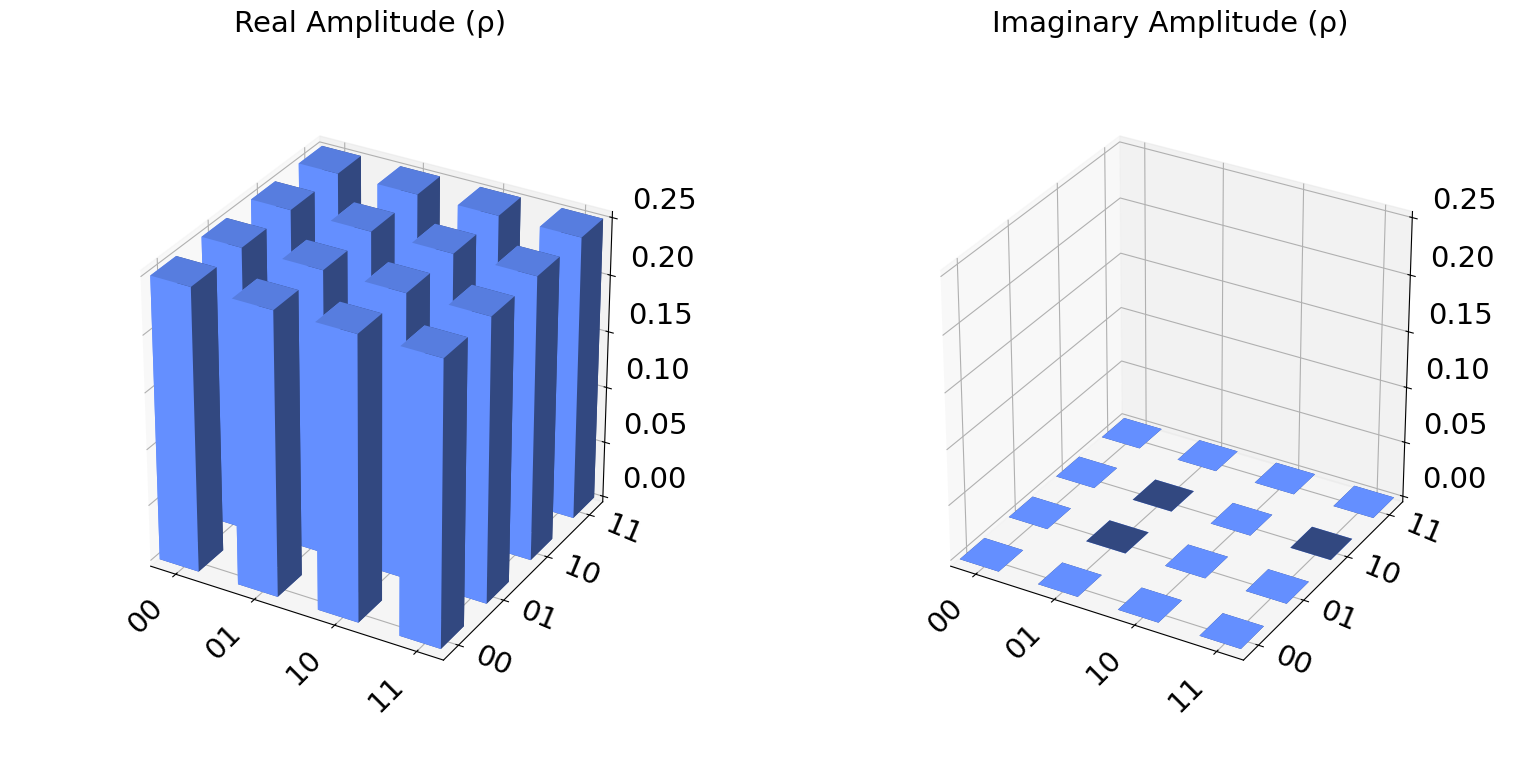

In [18]:
rho_circ_3.draw('city')

### 2.5 Compute the partial trace 

$\rho_{A} = Tr_{B}(\rho_{AB})$ 

In [19]:
partial_rho_circ_3 = qi.partial_trace(rho_circ_3, [0])
partial_rho_circ_3.data

array([[0.5+0.j, 0.5+0.j],
       [0.5+0.j, 0.5+0.j]])

### 2.6 Compute the expected value of an observable 

$\langle \hat{H} \rangle = \langle \psi | \hat{H} | \psi \rangle$, where $\hat{H}$ is the Hamiltonian operator.

In [20]:
expect_ops = psi_circ_3.expectation_value(unitary_circ_3)
expect_ops

(0.49999999999999967+0j)

### 2.7 Compute the the sample counts of measuring a state 

In [21]:
count_circ_3 = psi_circ_3.sample_counts(shots=1024)
count_circ_3

{'00': 254, '01': 278, '10': 259, '11': 233}

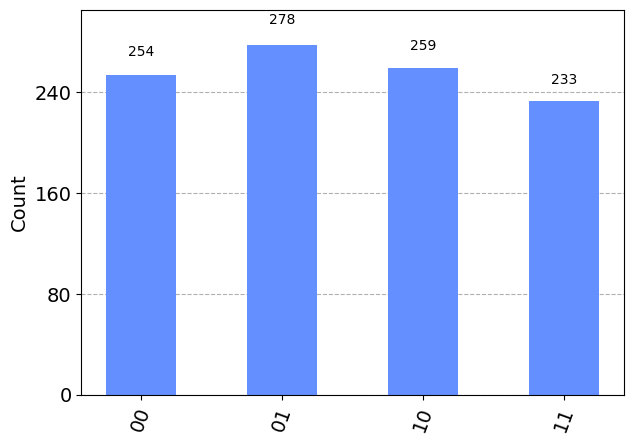

In [22]:
from qiskit.visualization import plot_histogram, plot_distribution

plot_histogram(count_circ_3)

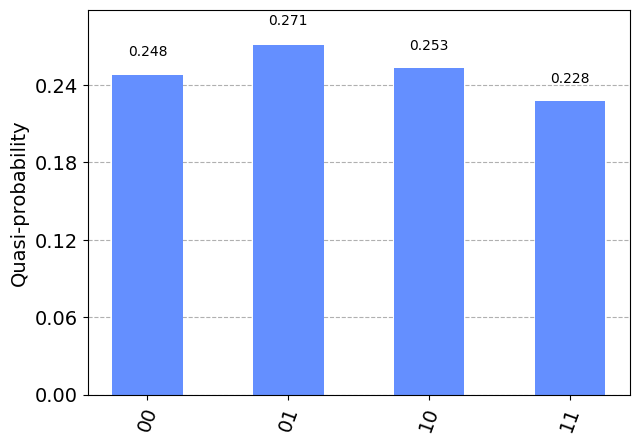

In [23]:
plot_distribution(count_circ_3)

### 2.8 Synthesize unitary operations

In [24]:
import numpy as np
from qiskit import QuantumCircuit

# Define a unitary matrix
U = 0.5 * np.array([
    [1, 1, 1, 1],
    [-1, 1, -1, 1],
    [-1, -1, 1, 1],
    [-1, 1, 1, -1]
])

# Create a quantum circuit
circuit = QuantumCircuit(2)
# Apply the unitary matrix to the qubits
circuit.unitary(U, circuit.qubits)

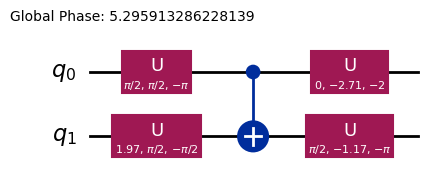

In [25]:
# compute unitary matrix of circuit
U = qi.Operator(circuit)

# re-synthesize
better_circuit = QuantumCircuit(2)
better_circuit.unitary(U, range(2))
better_circuit.decompose().draw('mpl')

In [26]:
qi.Operator(better_circuit).data == U.data

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

Qiskit's [`transpile`](https://docs.quantum.ibm.com/api/qiskit/compiler#qiskit.compiler.transpile) function automatically performs this re-synthesis for a sufficiently high optimization level.

### 2.9 Specify observables in the Pauli basis

In [27]:
observable = qi.SparsePauliOp.from_operator(U)
print(observable)

SparsePauliOp(['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ'],
              coeffs=[ 0.25+0.j  ,  0.25+0.j  ,  0.  +0.25j,  0.25+0.j  ,  0.25+0.j  ,
 -0.25+0.j  ,  0.  +0.25j, -0.25+0.j  ,  0.  +0.25j,  0.  +0.25j,
 -0.25+0.j  ,  0.  +0.25j,  0.25+0.j  , -0.25+0.j  ,  0.  +0.25j,
 -0.25+0.j  ])


## 3. Combining operator

### 3.1 Tensor product

`A.tensor(B)` = $A \otimes B$

In [28]:
A = qi.Operator(qi.operators.Pauli('X'))
B = qi.Operator(qi.operators.Pauli('Z'))

A.tensor(B)

Operator([[ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
          [ 0.+0.j, -0.+0.j,  0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [29]:
qi.SparsePauliOp("XZ").to_operator()

Operator([[ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


### 3.2 Tensor expansion

`A.expand(B)` = $B \otimes A$, where the subsystems indexed as matrix $A$ on subsystem 0, and matrix $B$ on subsystem 1.

In [30]:
A.expand(B)

Operator([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j],
          [ 0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [31]:
qi.SparsePauliOp("ZX").to_operator()

Operator([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
          [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


### 3.3 Composition

We can also compose two operators $A$ and $B$ to implement matrix multiplication using the `Operator.compose` method. We have that `A.compose(B)` returns the operator with matrix $B \cdot A$

In [32]:
A.compose(B)

Operator([[ 0.+0.j,  1.+0.j],
          [-1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))


`A.compose(B, front=True)` = $A \cdot B$

In [33]:
A.compose(B, front=True)

Operator([[ 0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))


### 3.4 Linear combination

Operators may also be combined using standard linear operators for addition, subtraction and scalar multiplication by complex numbers.

In [34]:
ZZ = qi.Operator(qi.operators.Pauli('ZZ'))
XX = qi.Operator(qi.operators.Pauli('XX'))
II = qi.Operator(qi.operators.Pauli('II'))

op = 0.2* ZZ - 0.3 * XX + 0.4 * II
op

Operator([[ 0.6+0.j,  0. +0.j,  0. +0.j, -0.3+0.j],
          [ 0. +0.j,  0.2+0.j, -0.3+0.j,  0. +0.j],
          [ 0. +0.j, -0.3+0.j,  0.2+0.j,  0. +0.j],
          [-0.3+0.j,  0. +0.j,  0. +0.j,  0.6+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [35]:
ops = qi.SparsePauliOp(['ZZ', 'XX', 'II'], [0.2, -0.3, 0.4])
ops.to_operator()

Operator([[ 0.6+0.j,  0. +0.j,  0. +0.j, -0.3+0.j],
          [ 0. +0.j,  0.2+0.j, -0.3+0.j,  0. +0.j],
          [ 0. +0.j, -0.3+0.j,  0.2+0.j,  0. +0.j],
          [-0.3+0.j,  0. +0.j,  0. +0.j,  0.6+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [36]:
# Check if the operator is unitary
ops.is_unitary()

False

## 4. Simulate circuit using `AerSimulator` & `fake_provider`

### 4.1 Simulate a quantum circuit using the `AerSimulator`

In [37]:
def ghz_state(num_qubits):
    '''
    Create a quantum circuit with the specified number of qubits
    '''
    ghz_circuit = QuantumCircuit(num_qubits)

    # Apply a Hadamard gate to the first qubit
    ghz_circuit.h(0)

    # Apply a series of CNOT gates
    for i in range(num_qubits - 1):
        ghz_circuit.cx(i, i + 1)
    ghz_circuit.measure_all()

    return ghz_circuit

In [38]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

def simulator_aer(circuit, sampling, method=None):
    '''
    Function to simulate the circuit using AerSimulator
    '''
    # Setting backend to AerSimulator
    sim_aer = AerSimulator()
    # Transpile the circuit
    circuit = transpile(circuit, sim_aer)
    # Execute the circuit
    result = sim_aer.run(circuit, shots=sampling, method=method).result()
    # Get the counts
    counts = result.get_counts()
    return counts

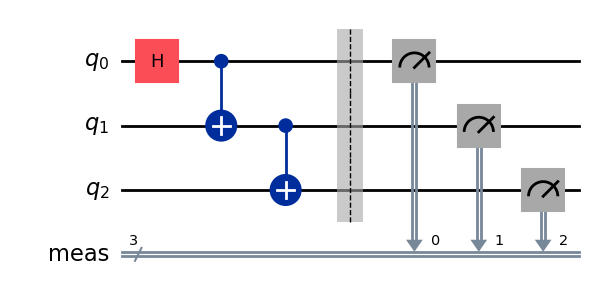

In [39]:
# Create a GHZ state with 3 qubits
GHZ3Qubits = ghz_state(3)

# Draw the circuit
GHZ3Qubits.draw('mpl')

In [40]:
# Simulate the GHZ state using AerSimulator
sampling = 1024
counts = simulator_aer(GHZ3Qubits, sampling)
# Print the counts
print(counts)

{'000': 520, '111': 504}


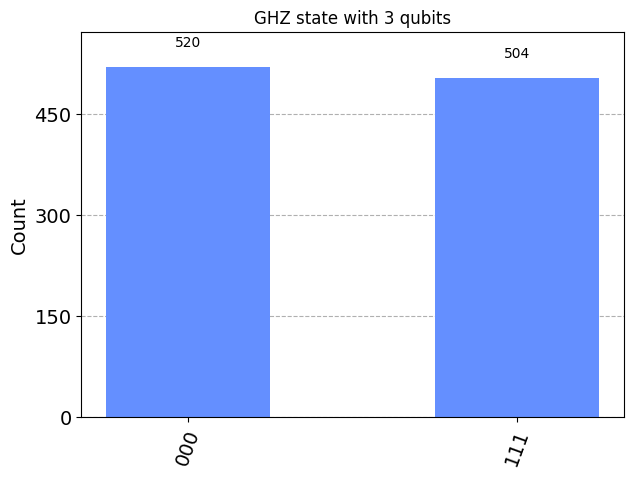

In [41]:
# plot the counts using plot_histogram
plot_histogram(counts, title='GHZ state with 3 qubits')

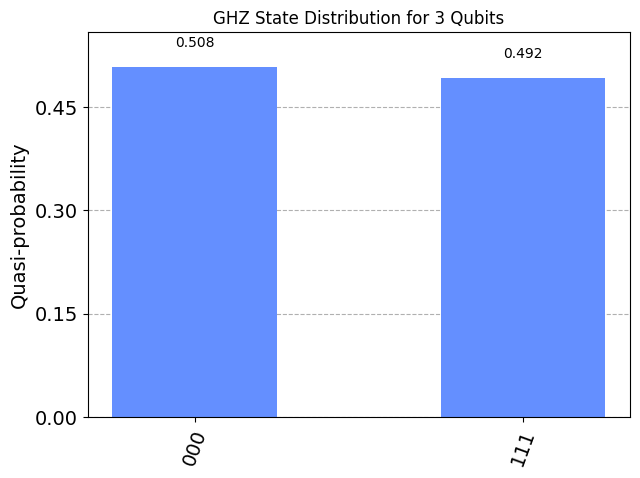

In [42]:
plot_distribution(counts, title='GHZ State Distribution for 3 Qubits') 

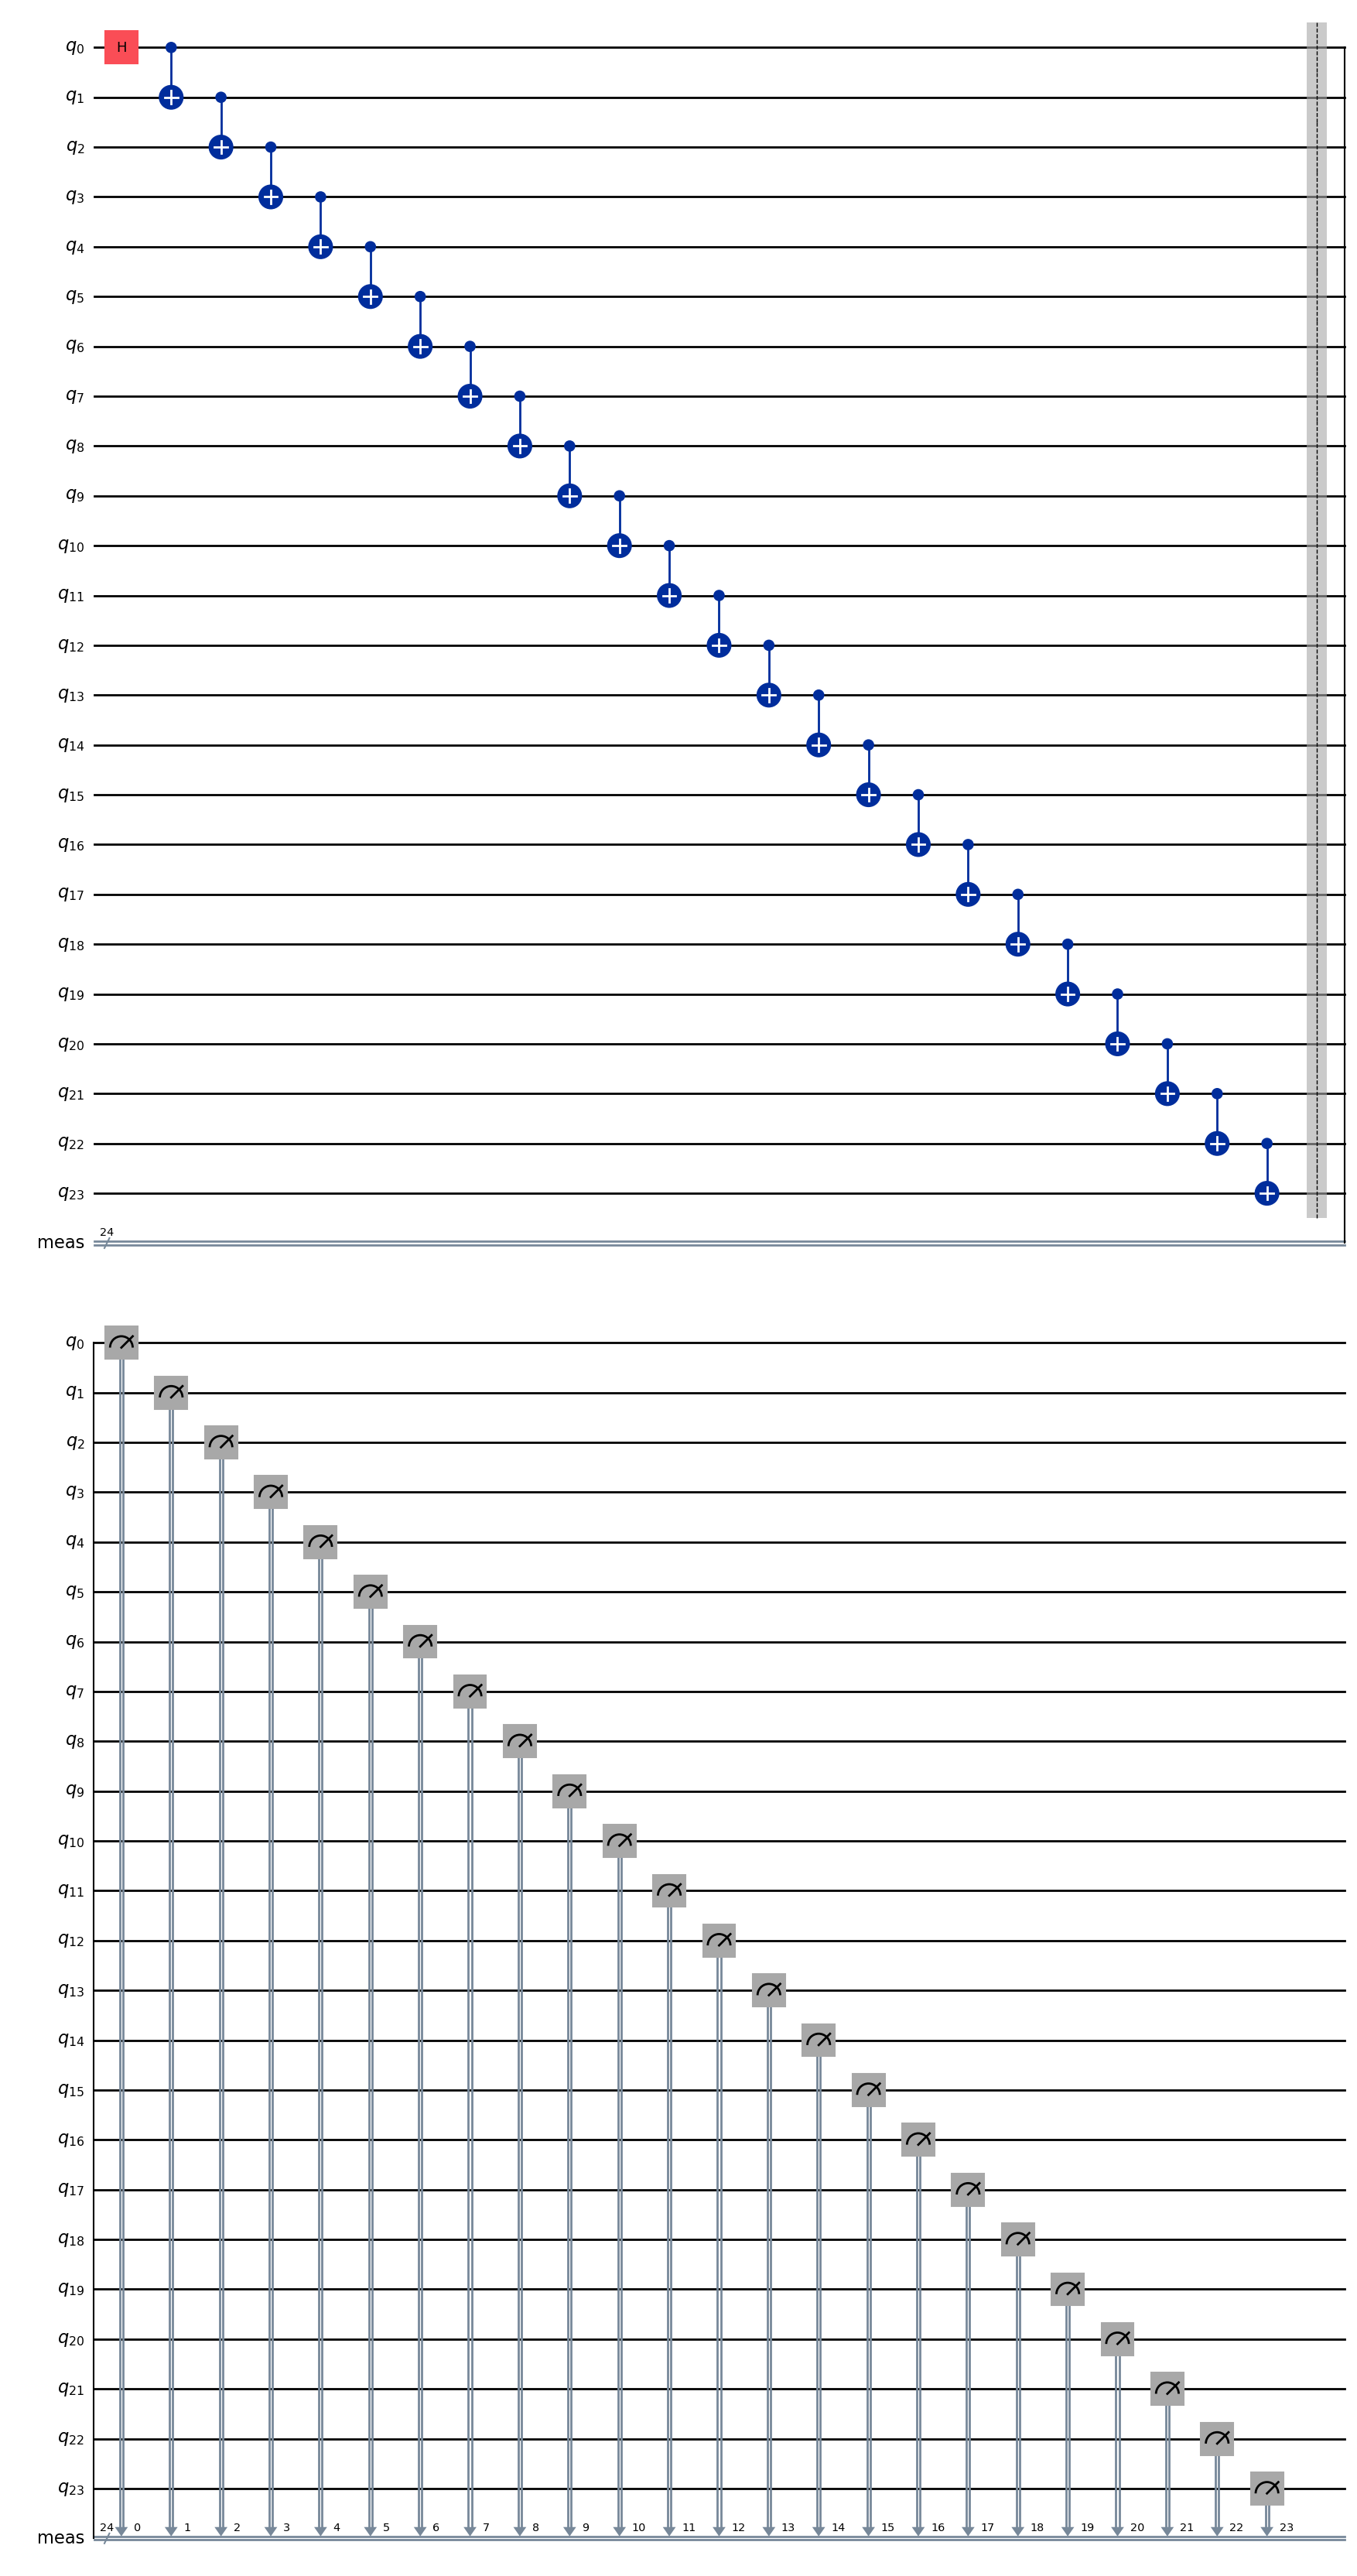

In [43]:
# Compute the GHZ state with 24 qubits
GHZ24Qubits = ghz_state(24)

# Draw the circuit
GHZ24Qubits.draw('mpl')

In [44]:
# Simulate the GHZ state using AerSimulator
sampling = 1024
counts = simulator_aer(GHZ24Qubits, sampling, method='matrix_product_state')
# Print the counts
print(counts)

{'111111111111111111111111': 507, '000000000000000000000000': 517}


For more about simulation method option please visit this [link](https://qiskit.github.io/qiskit-aer/tutorials/1_aersimulator.html)

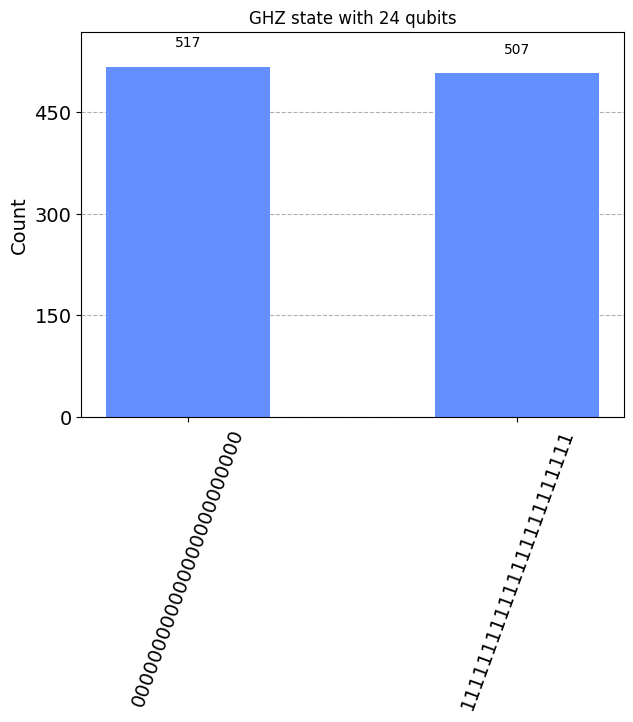

In [45]:
# plot the counts using plot_histogram
plot_histogram(counts, title='GHZ state with 24 qubits')

In [46]:
from qiskit_aer import noise

def simulator_aer_noise(circuit, sampling, method=None):
    '''
    Function to simulate the circuit using AerSimulator with noise
    '''
    # Setting backend to AerSimulator
    sim_aer = AerSimulator()
    # Probabilities for the depolarizing error
    prob = 0.1
    # Create a depolarizing error object with the specified probability for a single qubit
    error = noise.depolarizing_error(prob, 2)
    # Add the error to the noise model for the CNOT gate only
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['cx'])
    basis_gates = noise_model.basis_gates

    # Run the simulation with noise model
    result = sim_aer.run(circuit, 
                         shots=sampling, 
                         noise_model=noise_model, 
                         method=method, 
                         basis_gates=basis_gates).result()
    # Get the counts
    counts = result.get_counts()
    return counts

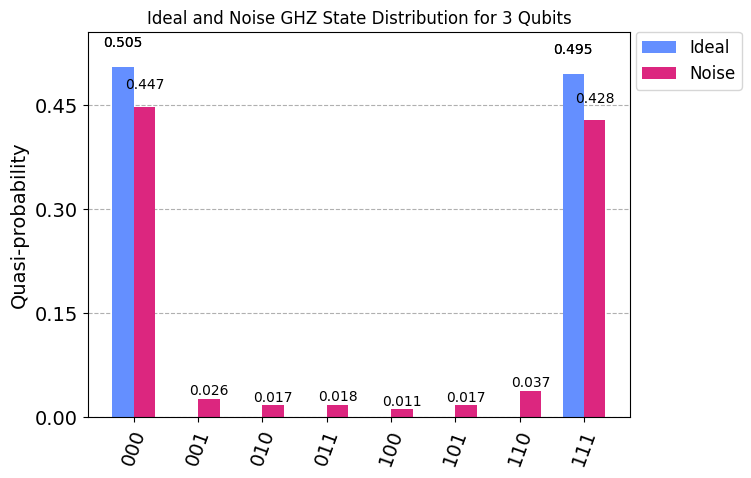

In [47]:
# Ideal GHZ state with 3 qubits
Ideal_GHZ3Qubits = simulator_aer(GHZ3Qubits, sampling=1024)
# Noise GHZ state with 3 qubits
Noise_GHZ3Qubits = simulator_aer_noise(GHZ3Qubits, sampling=1024)

# plot the counts using plot_distribution
plot_distribution([Ideal_GHZ3Qubits, Noise_GHZ3Qubits], title='Ideal and Noise GHZ State Distribution for 3 Qubits', legend=['Ideal', 'Noise'])


###  4.2 Connect with the IBMQ (Alternative)

#### Fake Provider
[The fake provider module](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/fake_provider) contains fake providers and fake backends classes. The fake backends are built to mimic the behaviors of IBM Quantum systems using system snapshots. The system snapshots contain important information about the quantum system such as coupling map, basis gates, qubit properties (T1, T2, error rate, etc.) which are useful for testing the transpiler and performing noisy simulation of the system.

In [48]:
def simulator_FakeProvider(circuit, sampling, backend):
    '''
    Function to simulate the circuit using a FakeProvider
    '''
    transpile_circuit = transpile(circuit, backend)
    job = backend.run(transpile_circuit, shots=sampling)
    result = job.result()
    counts = result.get_counts()
    return counts, transpile_circuit

In [49]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
# Get a FakeProvider backend
backend = FakeJakartaV2()

Transpilation is the process of rewriting a given input circuit to match the topology of a specific quantum device, and optimize the circuit instructions for execution on noisy quantum systems.

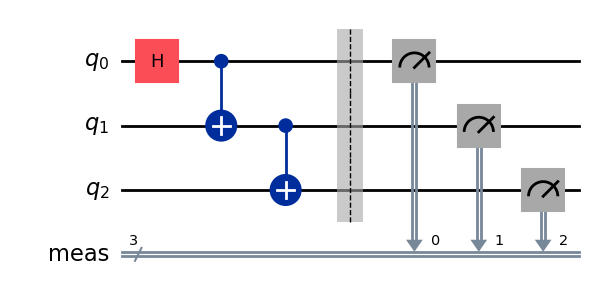

In [50]:
# Create a GHZ state with 3 qubits
GHZ3Qubits = ghz_state(3)

# Draw the circuit
GHZ3Qubits.draw('mpl')

In [51]:
# Simulate the GHZ state using FakeProvider
counts_FP, transpile_circuit_FP = simulator_FakeProvider(GHZ3Qubits, sampling=1024, backend=backend)

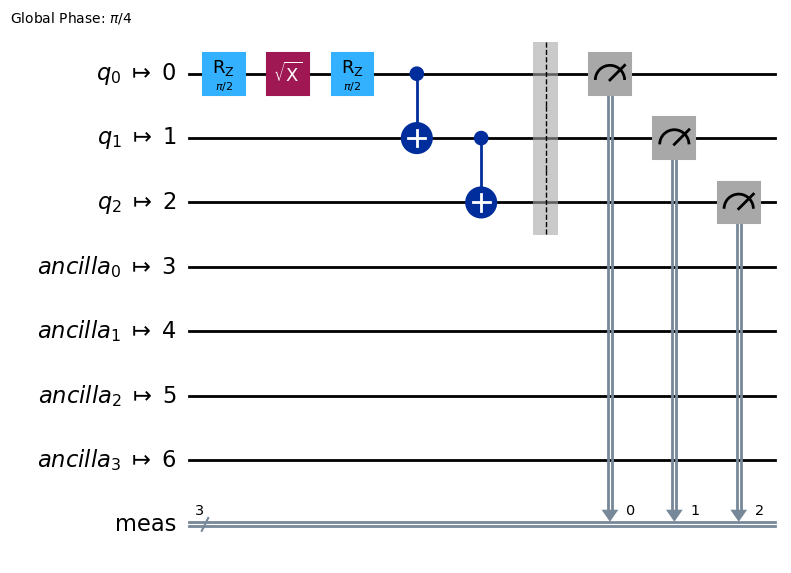

In [52]:
transpile_circuit_FP.draw('mpl')

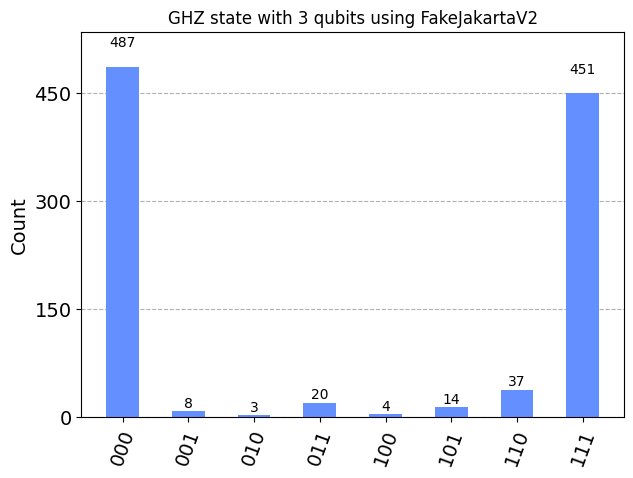

In [53]:
# plot the counts using plot_histogram
plot_histogram(counts_FP, title='GHZ state with 3 qubits using FakeJakartaV2')

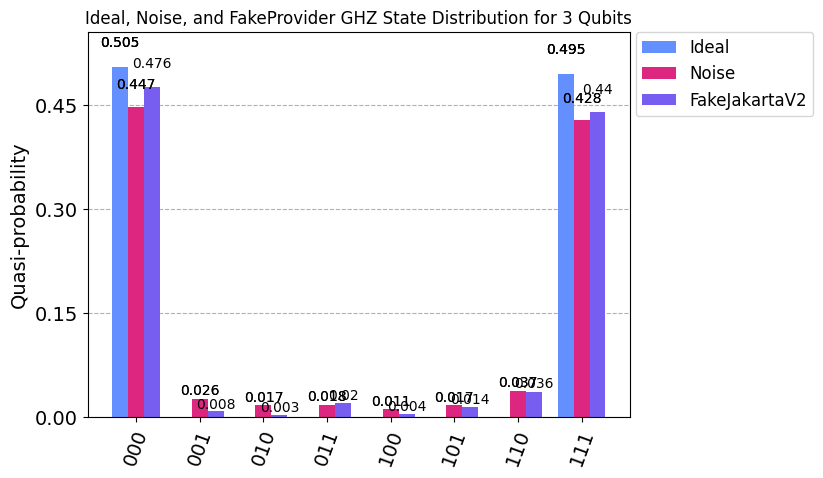

In [54]:
plot_distribution([Ideal_GHZ3Qubits, Noise_GHZ3Qubits, counts_FP], title='Ideal, Noise, and FakeProvider GHZ State Distribution for 3 Qubits', legend=['Ideal', 'Noise', 'FakeJakartaV2'])

## Jump into the real system (Simulating quantum many-body dynamics)

![adam_paper](../imag/adam-paper.png)

We consider one dimensional spin-$1/2$ chains, consisting of $N$ spins, initially prepared in either a domain wall configuration, $|\cdots \downarrow \downarrow \downarrow \uparrow \uparrow \uparrow \cdots\rangle$ and also in a Néel state, $|\cdots \downarrow \uparrow \downarrow \uparrow \cdots\rangle$. The Hamiltonian of the system is given by

$$
\hat{H} = -J \sum_{i=1}^{N-1} \left(\hat{\sigma}_{i}^{x} \hat{\sigma}_{i+1}^{x} + \hat{\sigma}_{i}^{y} \hat{\sigma}_{i+1}^{y}\right) + U \sum^{N-1}_{i=1}\hat{\sigma}^{z}_{i}\hat{\sigma}^{z}_{i+1} + h \sum_{i=1}^{N} \hat{\sigma}_{i}^{z} 
$$

![model_ising](../imag/model_ising.png)

In [55]:
from qiskit import QuantumCircuit
import numpy as np

from qiskit_aer import Aer

from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
# from qiskit_ibm_runtime.fake_provider import FakePoughkeepsieV2

# Set up plotting
import matplotlib.pyplot as plt
plt.style.use('./SciencePlots-APS.mplstyle')

![trotter-step](../imag/trotter-step.png)
![circuits](../imag/optimal_circuit.png)

In [56]:
#=======================================
# Define symmetric Trotter decomposition
# exp(-i*H*t) = (exp(-i*H*t/N))^N
# where N is the number of Trotter steps
#=======================================
def A_block(circ, num_qubits, initial_state="domain_wall"):
    if initial_state == "domain_wall":
        for i in range(num_qubits // 2):
            circ.x(i)
    elif initial_state == "Neel":
        for i in range(num_qubits):
            if i % 2 == 0:
                circ.x(i)
    else:
        raise ValueError("Invalid initial state. Choose 'domain_wall' or 'Neel'.")

def B_block(circ, num_qubits, dt):
    for i in range(1, num_qubits-1, 2):
        circ.rz(-np.pi/2., i+1)
        circ.cx(i+1, i)
        circ.rz(np.pi/2., i)
        circ.ry(dt-np.pi/2., i+1)
        circ.cx(i, i+1)
        circ.ry(np.pi/2.-dt, i+1)
        circ.cx(i+1, i)
        circ.rz(np.pi/2., i)

def C_block(circ, num_qubits, dt):
    for i in range (0, num_qubits, 2):
        circ.rz(-np.pi/2., i+1)
        circ.cx(i+1, i)
        circ.rz(np.pi/2., i)
        circ.ry(2.0*dt - np.pi/2., i+1)
        circ.cx(i, i+1)
        circ.ry(np.pi/2.-2.0*dt, i+1)
        circ.cx(i+1, i)
        circ.rz(np.pi/2., i)
    
def trotter_circuit(num_qubits, dt, num_steps, initial_state="domain_wall"):
    circ = QuantumCircuit(num_qubits)
    A_block(circ, num_qubits, initial_state)
    circ.barrier()
    for i in range(num_steps):
        B_block(circ, num_qubits, dt)
        circ.barrier()
        C_block(circ, num_qubits, dt)
        circ.barrier()
        B_block(circ, num_qubits, dt)
    # measure all qubits
    circ.measure_all()
    return circ

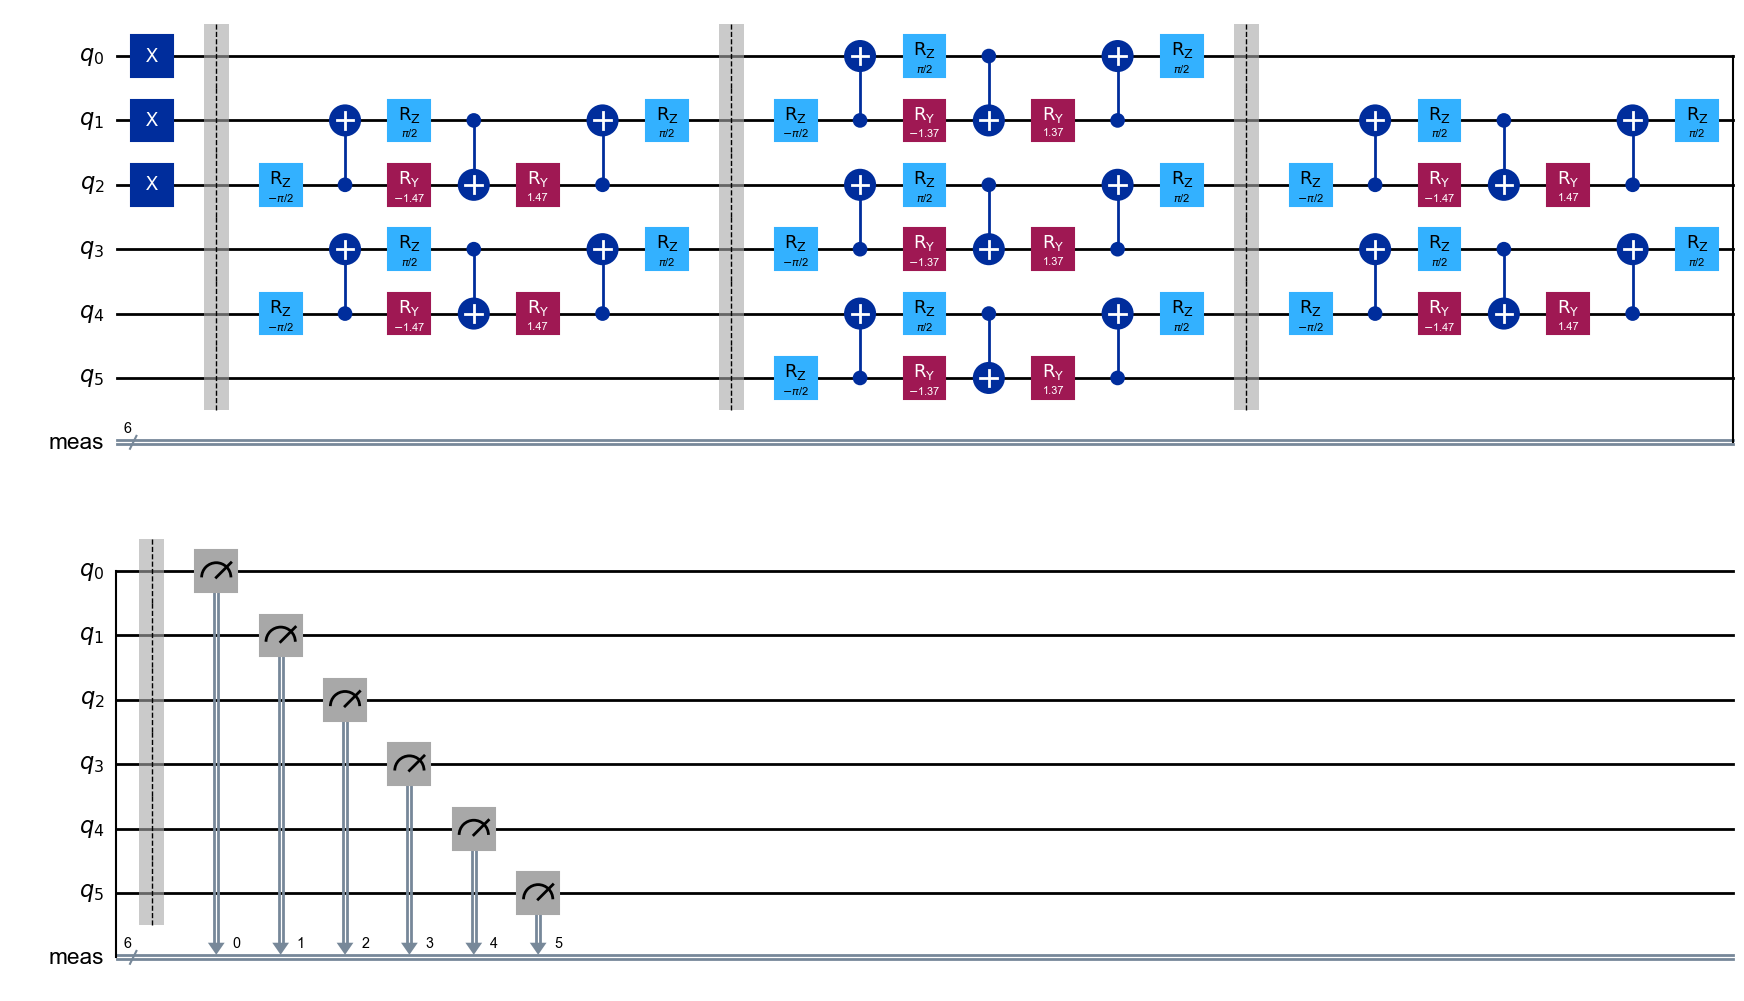

In [57]:
# Define the number of qubits
num_qubits = 6
# Define the time step
dt = 0.1
# Define the number of Trotter steps
num_steps = 1
# Create the circuit
circ = trotter_circuit(num_qubits, dt, num_steps, initial_state="domain_wall")
# Draw the circuit
circ.draw(output='mpl')

In [58]:
def simulator_aer(circuit, sampling):
    """
    Simulates the given quantum circuit and returns the measurement counts.
    """
    backend = Aer.get_backend('qasm_simulator')
    results = backend.run(circuit, shots=sampling).result()
    return results.get_counts()

def simulator_FakeProvider(circuit, sampling, backend):
    '''
    Function to simulate the circuit using a FakeProvider
    '''
    transpile_circuit = transpile(circuit, backend)
    job = backend.run(transpile_circuit, shots=sampling)
    result = job.result()
    counts = result.get_counts()
    return counts

def sigmaz_expect(counts, qubit_index, shots):
    """
    Computes the expectation value of the Pauli Z operator for the given qubit index.
    """
    plus_counts = 0
    minus_counts = 0
    for state, count in counts.items():
        if state[qubit_index] == '0':
            plus_counts += count
        else:
            minus_counts += count
    expectation_value = (plus_counts - minus_counts) / shots
    return expectation_value

def trotter_evolution(num_qubits, dt, num_steps, idx, sampling, ideal=True):
    """
    Simulates the Trotterized evolution of the XX Ising chain model and returns the expectation values of the Pauli Z operator.
    """
    circ = trotter_circuit(num_qubits, dt, num_steps)
    if ideal:
        counts = simulator_aer(circ, sampling)
    else:
        counts = simulator_FakeProvider(circ, sampling, backend=backend)
    shots = sum(counts.values())
    # Compute the expectation values of the Pauli Z operator only for the qubit at the given index idx
    expect_vals = sigmaz_expect(counts, idx, shots)
    return expect_vals

In [59]:
# Define the number of qubits
num_qubits = 6
# Define the time step
dt = 0.1
# Define the number of Trotter steps
num_steps = 25
# Define the number of samples
sampling = 1024
# Define the qubit index
idx = num_qubits - 4  # for 4th qubit from the end
# Define the initial state
initial_state = "domain_wall"
# Define backend
backend = FakeJakartaV2()
# backend = FakePoughkeepsieV2()

In [60]:
# Simulate the Trotterized evolution for each Trotter steps and compute the expectation values of the Pauli Z operator for the given qubit index with Ideal
expect_vals_ideal = [trotter_evolution(num_qubits, dt, i, idx, sampling, ideal=True) for i in range(1, num_steps+1)]

# Simulate the Trotterized evolution for each Trotter steps and compute the expectation values of the Pauli Z operator for the given qubit index with FakeJakartaV2
expect_vals_FP = [trotter_evolution(num_qubits, dt, i, idx, sampling, ideal=False) for i in range(1, num_steps+1)]

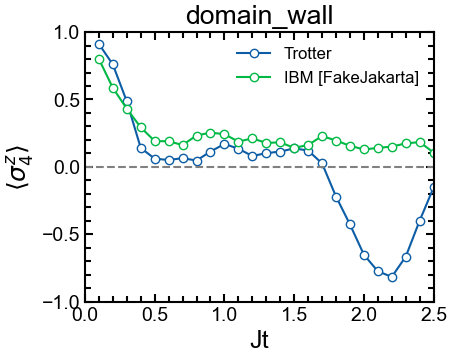

In [61]:
# Plot the expectation values
fig = plt.figure(figsize=(4.5, 3.5))

plt.plot(dt*np.arange(1, num_steps+1), expect_vals_ideal, '.-', ms=12, mfc='w', label='Trotter')
plt.plot(dt*np.arange(1, num_steps+1), expect_vals_FP, '.-', ms=12, mfc='w', label='IBM [FakeJakarta]')
plt.axhline(y=0, color='gray', linestyle='--')

plt.xlim(0, dt*num_steps)
plt.ylim(-1, 1)

plt.xlabel('Jt')
plt.ylabel(r'$\langle \sigma^{z}_{4} \rangle$')

plt.legend(loc='best')

plt.title(r'{}'.format(initial_state))
plt.show()